In [ ]:
import sys
from pathlib import Path
import importlib
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import skimage as sk
from skimage.filters import wiener
from skimage import filters
from skimage.restoration import richardson_lucy, wiener

%load_ext autoreload
%autoreload 2
sys.path.append('../src/')
import proj

In [ ]:
%reload_ext autoreload
import proj
filt = proj.Filters('../data/stage1/')
# ret = filt.evaluate()
# filt.evaluate('gaussian_blur')

Finding Gaussian kernel: https://dsp.stackexchange.com/questions/35768/estimating-the-standard-deviation-of-gaussian-filter-from-smoothed-image  

In [ ]:
a = 1.0

# fit a gaussian to the first row of the gaussians
def fourier_gaussian(x, sigma, mean=0.0):
    return a * np.exp(-2*(np.pi*(x-mean)*sigma)**2)


def gaussian1d(x, a, x0, sigma):
    return a * np.exp(-(x-x0)**2 / (2*sigma**2))


def gaussian2d(h: int, w: int, sigma: float, a: float = 1.0) -> np.ndarray:
    """Create a 2D Gaussian filter.
    """
    x = np.linspace(-w/2, w/2, w)
    y = np.linspace(-h/2, h/2, h)
    X, Y = np.meshgrid(x, y)
    ret = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    return a * ret / np.sum(ret)

gaussian_avg = []
for i in range(len(filt.imgs_truth)):
    img_blur = filt.imgs['gaussian_blur'][i]
    img_truth = filt.imgs_truth[i]

    img_blur_fft = np.fft.fft2(img_blur)
    img_truth_fft = np.fft.fft2(img_truth)

    tol = 1e-2
    img_truth_fft = np.where(np.abs(img_truth_fft) < tol, tol, img_truth_fft)
    div = np.abs(img_blur_fft / img_truth_fft)
    gaussians = np.fft.fftshift(np.abs(div[0,:]))

    for j in range(3):
        gaussian_avg.append(gaussians[:,j])

gaussian_avg = np.array(gaussian_avg)
gaussian_avg = np.median(gaussian_avg, axis=0)
N = gaussian_avg.shape[0]

# Smooth signal
gaussian_avg = savgol_filter(gaussian_avg, 20, 1)

# # Set left and right ends of signal to 0
# maxval = np.max(gaussian_avg)
# for i in range(N//2-1):
#     if gaussian_avg[i] < maxval/35:
#         gaussian_avg[N//2+i:] = 0
#         gaussian_avg[:N//2-i] = 0
#         break

sigma = 0.7
x = np.linspace(-np.pi, np.pi, N)
plt.plot(x, gaussian_avg)
y = fourier_gaussian(x, sigma)
plt.plot(x, y)

h, w, = img_blur.shape[:2]
psf = gaussian2d(h, w, sigma)
print("psf min/max: ", psf.max(), psf.min())

n = gaussian_avg.shape[0]
x = np.linspace(-n/2, n/2, n)
popt, pcov = curve_fit(fourier_gaussian, x, gaussian_avg)
sigma = abs(popt[0])
print(a, sigma, 1/sigma)

In [ ]:
def calc_sigma(img_truth: np.ndarray, img_blur: np.ndarray, start: float = 0, end: float = 5) -> float:
    """Runs binary search to find the  standard deviation of the Gaussian
    """
    img_blur = cv2.cvtColor(img_blur, cv2.COLOR_RGB2YUV)[:,:,0]/255
    img_truth = cv2.cvtColor(img_truth, cv2.COLOR_RGB2YUV)[:,:,0]/255
    h, w = img_blur.shape[:2]
    error_min = 1e9
    sigma = (start + end) / 2
    while start < end:
        img_blur2 = filters.gaussian(img_truth, sigma=sigma)
        err = np.mean(np.abs(img_blur2 - img_blur))
        if err < error_min:
            error_min = err
            start = sigma
        else:
            end = sigma
        sigma = (start + end) / 2
    return sigma

img_blur = filt.imgs['gaussian_blur'][0]
img_truth = filt.imgs_truth[0]
sigma = calc_sigma(img_truth, img_blur)
print(sigma) # prints 3.75

# img_blur2 = filters.gaussian(img_truth[:,:,channel]/255, sigma=sigma)
# print(np.mean(np.abs(img_blur2 - img_blur[:,:,channel]/255)))
# sigma = 3.5 # I manually played around with some values and 3.5 is better

In [116]:
%reload_ext autoreload
import proj
eval = proj.FilterEvaluator('../data/stage1/')
# eval.run()
eval.run('sp_noise')
# eval.run('gaussian_blur')

[(26.765740881545092, 0.9232724604869724, 'sp_noise')]
sp_noise: PASS


{'sp_noise': (26.765740881545092, 0.9232724604869724)}

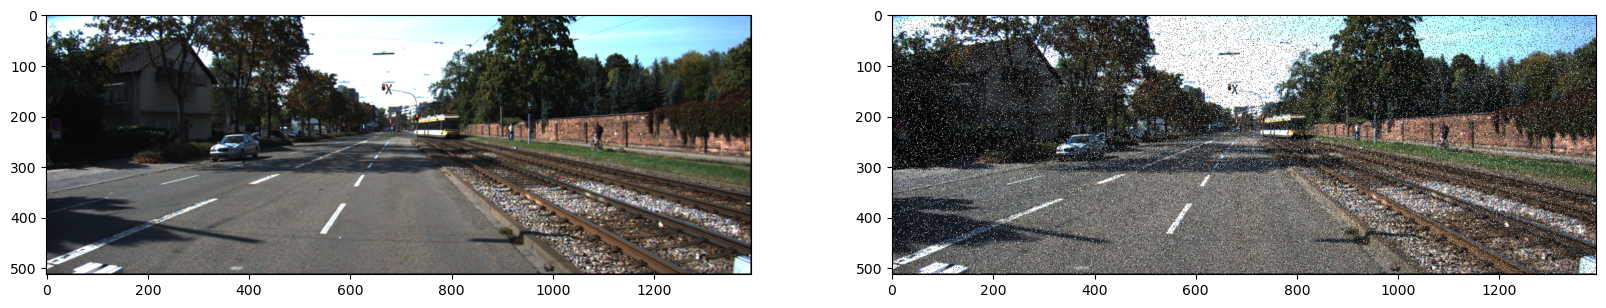

In [106]:
eval.plot('sp_noise')